In [17]:
# Importing necessary libraries for data manipulation, visualization, and modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import xgboost as xgb
from sklearn.impute import SimpleImputer

# Load the Titanic datasets (train and test)
train_data = pd.read_csv('Titanic_train.csv')
test_data = pd.read_csv('Titanic_test.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [18]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [19]:
# ------------------ 1. Exploratory Data Analysis (EDA) ------------------

# Checking for missing values in the training and test datasets
print("Missing values in training set:")
print(train_data.isnull().sum())
print("\nMissing values in test set:")
print(test_data.isnull().sum())

Missing values in training set:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Missing values in test set:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


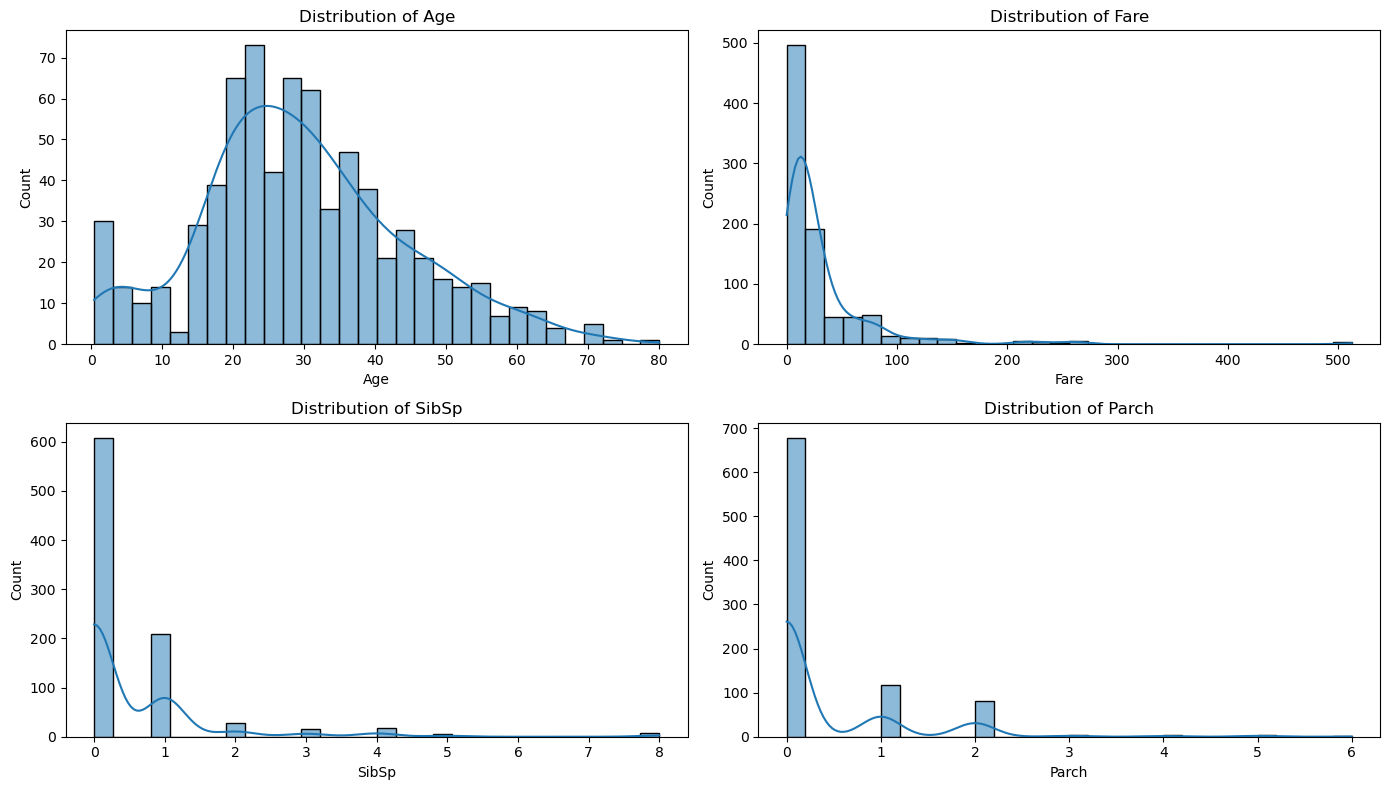

In [20]:
# Visualizing numerical feature distributions: 'Age', 'Fare', 'SibSp', 'Parch'
numerical_features = ['Age', 'Fare', 'SibSp', 'Parch']
plt.figure(figsize=(14, 8))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(train_data[feature].dropna(), kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

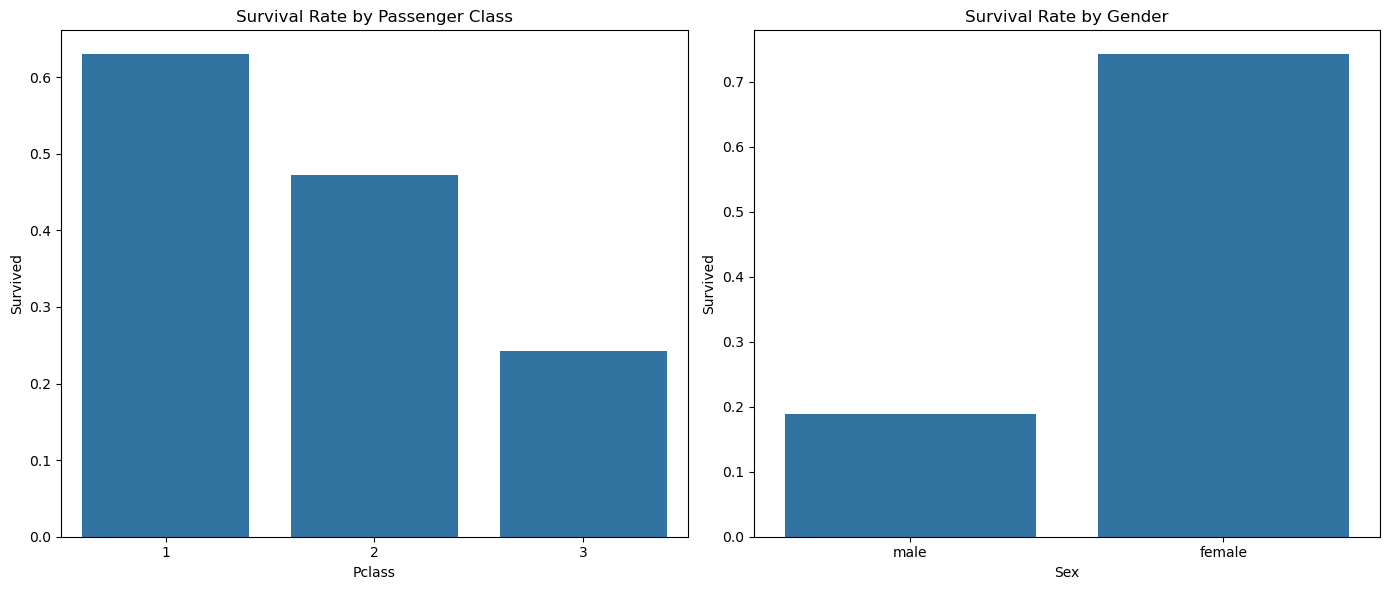

In [22]:
# Visualizing relationships between features and survival using bar plot
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Pclass', y='Survived', data=train_data, errorbar=None)
plt.title('Survival Rate by Passenger Class')

plt.subplot(1, 2, 2)
sns.barplot(x='Sex', y='Survived', data=train_data, errorbar=None)
plt.title('Survival Rate by Gender')
plt.tight_layout()
plt.show()

In [25]:
# ------------------ 2. Data Preprocessing ------------------

# Impute missing values for 'Age' with the median and for 'Embarked' with the mode
imputer_age = SimpleImputer(strategy='median')
imputer_embarked = SimpleImputer(strategy='most_frequent')

# Imputing missing values using dictionary format
train_data.fillna({
    'Age': train_data['Age'].median(),
    'Embarked': train_data['Embarked'].mode()[0]
}, inplace=True)

test_data.fillna({
    'Age': test_data['Age'].median(),
    'Fare': test_data['Fare'].median()
}, inplace=True)

In [29]:
# Encoding categorical variables: 'Sex' and 'Embarked'
label_encoder = LabelEncoder()

train_data['Sex'] = label_encoder.fit_transform(train_data['Sex'])
test_data['Sex'] = label_encoder.transform(test_data['Sex'])

train_data['Embarked'] = label_encoder.fit_transform(train_data['Embarked'])
test_data['Embarked'] = label_encoder.transform(test_data['Embarked'])

# Defining features (X) and target (y)
X = train_data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Survived'])
y = train_data['Survived']

# Splitting data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [31]:
# ------------------ 3. Building Predictive Models ------------------

# Helper function to evaluate model performance
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

In [32]:
# 3a. LightGBM model
print("Training LightGBM model...")
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)
lgb_preds = lgb_model.predict(X_test)

# Evaluate LightGBM model
print("\nLightGBM Model Performance:")
evaluate_model(y_test, lgb_preds)

Training LightGBM model...
[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 194
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

In [4]:
!pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.5/124.9 MB 3.4 MB/s eta 0:00:38
    --------------------------------------- 1.6/124.9 MB 4.9 MB/s eta 0:00:25
    --------------------------------------- 2.6/124.9 MB 4.9 MB/s eta 0:00:26
   - -------------------------------------- 4.5/124.9 MB 5.8 MB/s eta 0:00:21
   -- ------------------------------------- 6.3/124.9 MB 6.5 MB/s eta 0:00:19
   -- ------------------------------------- 8.7/124.9 MB 7.4 MB/s eta 0:00:16
   --- ------------------------------------ 11.3/124.9 MB 8.3 MB/s eta 0:00:14
   ---- ----------------------------------- 14.7/124.9 MB 9.3 MB/s eta 0:00:12
   ----- ---------------------------------- 18.6/124.9 MB 10.5 MB/s eta 0:00:11
   ------- -------------------------------- 22.8/124.9 MB 11.5 MB/s eta 0:00:09
   -------- ------------------------------- 27.3/124.9 MB 12.4 MB/s eta 0:00:08
   ---------- ----------------------------- 32.8/124.9 MB 13.7 

In [33]:
# 3b. XGBoost model
print("\nTraining XGBoost model...")
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# Evaluate XGBoost model
print("\nXGBoost Model Performance:")
evaluate_model(y_test, xgb_preds)


Training XGBoost model...

XGBoost Model Performance:
Accuracy: 0.7877
Precision: 0.7368
Recall: 0.7568
F1-Score: 0.7467

Confusion Matrix:
[[85 20]
 [18 56]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       105
           1       0.74      0.76      0.75        74

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



In [36]:
# ------------------ 4. Comparative Analysis with Cross-validation ------------------

# 4a. Cross-validate the models using 5-fold cross-validation
print("\nCross-validating models...")

lgb_cv = cross_val_score(lgb_model, X_train, y_train, cv=5, scoring='accuracy').mean()
xgb_cv = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='accuracy').mean()


Cross-validating models...
[LightGBM] [Info] Number of positive: 214, number of negative: 355
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 179
[LightGBM] [Info] Number of data points in the train set: 569, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376098 -> initscore=-0.506142
[LightGBM] [Info] Start training from score -0.506142
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

In [38]:
print(f"LightGBM CV Accuracy: {lgb_cv:.4f}")
print(f"XGBoost CV Accuracy: {xgb_cv:.4f}")
# 4b. Comparative performance summary
print("\nComparative Performance Summary:")
print(f"LightGBM Accuracy: {accuracy_score(y_test, lgb_preds):.4f}")
print(f"XGBoost Accuracy: {accuracy_score(y_test, xgb_preds):.4f}")

LightGBM CV Accuracy: 0.8174
XGBoost CV Accuracy: 0.8034

Comparative Performance Summary:
LightGBM Accuracy: 0.8212
XGBoost Accuracy: 0.7877


In [53]:
# Visualize the comparison using a bar chart
model_comparison = pd.DataFrame({
    'Model': ['LightGBM', 'XGBoost'],
    'Accuracy': [accuracy_score(y_test, lgb_preds), accuracy_score(y_test, xgb_preds)],
    'Precision': [precision_score(y_test, lgb_preds), precision_score(y_test, xgb_preds)],
    'Recall': [recall_score(y_test, lgb_preds), recall_score(y_test, xgb_preds)],
    'F1-Score': [f1_score(y_test, lgb_preds), f1_score(y_test, xgb_preds)]
})

In [52]:
model_comparison

,Accuracy,Precision,Recall,F1-Score
Model,,,,
LightGBM,0.821229,0.783784,0.783784,0.783784
XGBoost,0.787709,0.736842,0.756757,0.746667


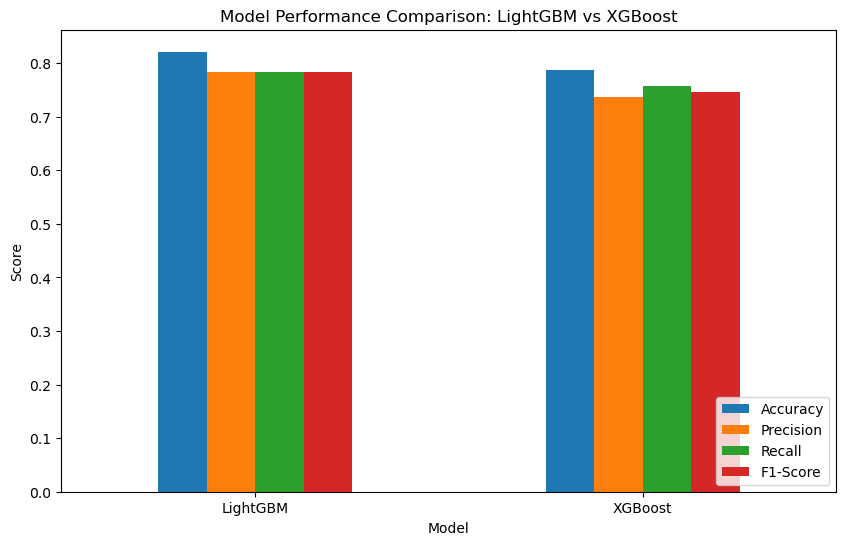

In [54]:
model_comparison.set_index('Model', inplace=True)
model_comparison.plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Comparison: LightGBM vs XGBoost')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()

In [50]:
# ------------------ 4. Comparative Analysis with Hyperparameter Tuning ------------------

# 4a. Hyperparameter tuning for LightGBM
print("Hyperparameter tuning for LightGBM...")
lgb_param_grid = {
    'num_leaves': [31, 50],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200]
}

lgb_model = lgb.LGBMClassifier(random_state=42)

lgb_grid = GridSearchCV(lgb_model, param_grid=lgb_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
lgb_grid.fit(X_train, y_train)

print(f"--Best parameters for LightGBM: {lgb_grid.best_params_}")
lgb_best_model = lgb_grid.best_estimator_

Hyperparameter tuning for LightGBM...
[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 194
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

In [46]:
# Predict and evaluate with the tuned LightGBM model
lgb_best_preds = lgb_best_model.predict(X_test)
print("\nTuned LightGBM Model Performance:")
evaluate_model(y_test, lgb_best_preds)


Tuned LightGBM Model Performance:
Accuracy: 0.8045
Precision: 0.8095
Recall: 0.6892
F1-Score: 0.7445

Confusion Matrix:
[[93 12]
 [23 51]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       105
           1       0.81      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



In [51]:
# 4b. Hyperparameter tuning for XGBoost
print("\nHyperparameter tuning for XGBoost...")
xgb_param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'colsample_bytree': [0.3, 0.7]
}

xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')

xgb_grid = GridSearchCV(xgb_model, param_grid=xgb_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
xgb_grid.fit(X_train, y_train)

print(f"--Best parameters for XGBoost: {xgb_grid.best_params_}")
xgb_best_model = xgb_grid.best_estimator_


Hyperparameter tuning for XGBoost...
--Best parameters for XGBoost: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


In [48]:
# Predict and evaluate with the tuned XGBoost model
xgb_best_preds = xgb_best_model.predict(X_test)
print("\nTuned XGBoost Model Performance:")
evaluate_model(y_test, xgb_best_preds)


Tuned XGBoost Model Performance:
Accuracy: 0.8156
Precision: 0.8060
Recall: 0.7297
F1-Score: 0.7660

Confusion Matrix:
[[92 13]
 [20 54]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       105
           1       0.81      0.73      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.82      0.82      0.81       179



Hyperparameter tuning for LightGBM...
[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 194
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

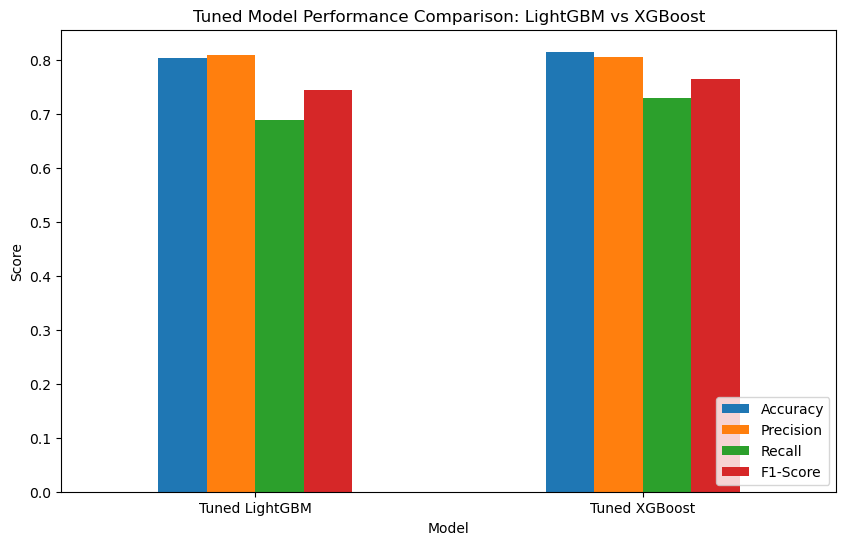

In [28]:
# 4c. Comparative performance summary after hyperparameter tuning
print("\nComparative Performance Summary after Hyperparameter Tuning:")
print(f"Tuned LightGBM Accuracy: {accuracy_score(y_test, lgb_best_preds):.4f}")
print(f"Tuned XGBoost Accuracy: {accuracy_score(y_test, xgb_best_preds):.4f}")

In [44]:
# Visualize the comparison using a bar chart
tuned_model_comparison = pd.DataFrame({
    'Model': ['Tuned LightGBM', 'Tuned XGBoost'],
    'Accuracy': [accuracy_score(y_test, lgb_best_preds), accuracy_score(y_test, xgb_best_preds)],
    'Precision': [precision_score(y_test, lgb_best_preds), precision_score(y_test, xgb_best_preds)],
    'Recall': [recall_score(y_test, lgb_best_preds), recall_score(y_test, xgb_best_preds)],
    'F1-Score': [f1_score(y_test, lgb_best_preds), f1_score(y_test, xgb_best_preds)]
})

In [43]:
tuned_model_comparison

,Accuracy,Precision,Recall,F1-Score
Model,,,,
Tuned LightGBM,0.804469,0.809524,0.689189,0.744526
Tuned XGBoost,0.815642,0.805970,0.729730,0.765957


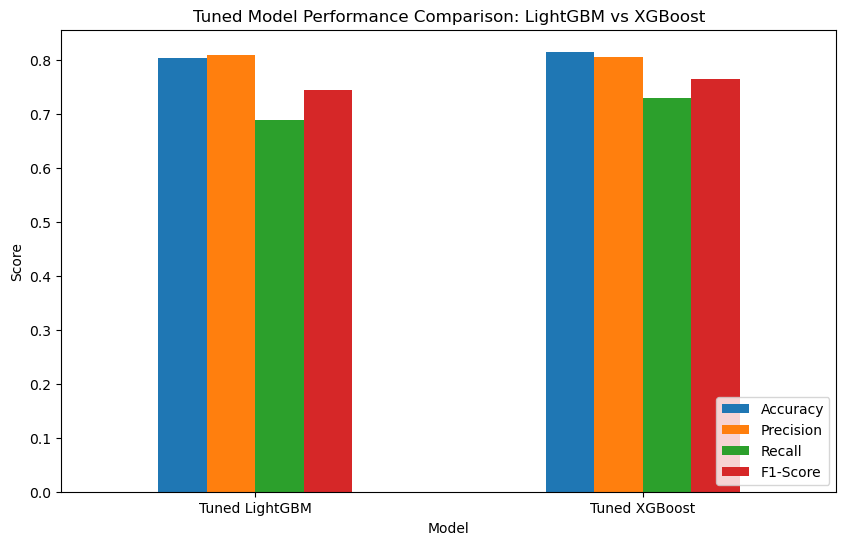

In [45]:
tuned_model_comparison.set_index('Model', inplace=True)
tuned_model_comparison.plot(kind='bar', figsize=(10, 6))
plt.title('Tuned Model Performance Comparison: LightGBM vs XGBoost')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()